<a href="https://colab.research.google.com/github/cdiegor/Simulacao/blob/main/Projeto_Experimentos_Simulacao_MMc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Experimentos de Simulação — M/M/c

Este notebook cobre:
- **Design de experimentos de simulação** (objetivos, fatores, respostas, plano).
- **Replicações, batching e estimação de variância** (ICs, técnicas e pitfalls).
- **Verificação & validação (V&V)** (comparação com teoria M/M/c e checagens).
- **Debugging e credibilidade do modelo** (tracing, asserts e checklist).

Modelo base: **fila M/M/c**.

In [ ]:
!pip install simpy

In [ ]:
import math
import numpy as np
import simpy
import matplotlib.pyplot as plt

def make_rng(seed=None):
    return np.random.default_rng(seed)


In [ ]:
class MMc2:
    def __init__(self, env, lam, mu, c, rng):
        self.env = env
        self.lam = float(lam)
        self.mu = float(mu)
        self.c = int(c)
        self.rng = rng
        self.serv = simpy.Resource(env, capacity=self.c)
        self.records = []
        env.process(self._arrival_process())

    def _arrival_process(self):
        while True:
            ia = self.rng.exponential(1.0 / self.lam)
            yield self.env.timeout(ia)
            self.env.process(self._patient())

    def _service_time(self):
        return self.rng.exponential(1.0 / self.mu)

    def _patient(self):
        t_arr = self.env.now
        with self.serv.request() as req:
            yield req
            t_start = self.env.now
            st = self._service_time()
            yield self.env.timeout(st)
            t_dep = self.env.now
        self.records.append((t_arr, t_start, t_dep))

def simulate_run(lam, mu, c, T, warmup=0.0, seed=None):
    rng = make_rng(seed)
    env = simpy.Environment()
    model = MMc2(env, lam, mu, c, rng)
    env.run(until=T)
    wq_list, w_list = [], []
    for t_arr, t_start, t_dep in model.records:
        if t_arr >= warmup:
            wq_list.append(t_start - t_arr)
            w_list.append(t_dep - t_arr)
    return {
        "n_completed": len(w_list),
        "Wq_mean": float(np.mean(wq_list)) if wq_list else float("nan"),
        "W_mean": float(np.mean(w_list)) if w_list else float("nan"),
        "Wq_all": np.array(wq_list, dtype=float),
        "W_all": np.array(w_list, dtype=float),
    }


In [ ]:
from math import sqrt
from scipy.stats import t as student_t

def run_replications(lam, mu, c, T, warmup, R=30, seed_base=1234):
    rng = make_rng(seed_base)
    ys = []
    for r in range(R):
        seed = int(rng.integers(0, 2**63-1))
        res = simulate_run(lam, mu, c, T, warmup, seed)
        ys.append(res["Wq_mean"])
    y = np.array(ys, dtype=float)
    m = float(np.nanmean(y))
    s = float(np.nanstd(y, ddof=1))
    half = student_t.ppf(0.975, R-1) * s / sqrt(R) if R>1 else float("nan")
    return {"R": R, "mean": m, "sd": s, "halfwidth95": half, "samples": y}


In [ ]:
def batch_means(values, B):
    import math
    values = np.asarray(values, dtype=float)
    N = values.size
    if B <= 1 or N < B:
        raise ValueError("Escolha B>=2 e N>=B")
    m = N // B
    trimmed = values[:m*B]
    batches = trimmed.reshape(B, m).mean(axis=1)
    R = B
    mean_b = float(batches.mean())
    sd_b = float(batches.std(ddof=1))
    from scipy.stats import t as student_t
    half = student_t.ppf(0.975, R-1) * sd_b / math.sqrt(R) if R>1 else float("nan")
    return {"B": B, "batch_mean": mean_b, "batch_sd": sd_b, "halfwidth95": half, "batches": batches}


In [53]:
def moving_average(x, k):
    x = np.asarray(x, dtype=float)
    if k <= 1:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    ma = (cumsum[k:] - cumsum[:-k]) / k
    return ma

def plot_welch(w_series, k=200):
    ma = moving_average(w_series, k)
    print(ma)
    plt.figure()
    plt.plot(ma)
    plt.xlabel("índice")
    plt.ylabel("média móvel de Wq")
    plt.title("Welch — inspeção de aquecimento")
    plt.grid(True)
    plt.show()


In [ ]:
def erlang_c_wait_mean(lam, mu, c):
    lam = float(lam); mu = float(mu); c = int(c)
    rho = lam / (c*mu)
    if rho >= 1.0:
        return math.inf
    a = c*rho
    s = 0.0
    term = 1.0
    for n in range(c):
        if n>0:
            term *= a / n
        s += term
    term *= a / c
    tail = term / (1.0 - rho)
    denom = s + tail
    C = tail / denom
    Wq = C / (c*mu - lam)
    return Wq


In [45]:
# Experimentos de verificação (comparar com teoria) e ICs por replicações
mu = 6.0
scenarios = [(lam, c) for lam in [9, 10, 11] for c in [2,3,4]]
T = 1000.0     # 8h
warmup = 100.0
R = 100

print("lam  c   Wq_mean   ±half95   Wq_theory")
for lam, c in scenarios:
    lam_m = lam/60.0; mu_m = mu/60.0
    rep = run_replications(lam_m, mu_m, c, T, warmup, R=R, seed_base=2025 + int(lam*10 + c))
    Wq_the = erlang_c_wait_mean(lam_m, mu_m, c)
    print(f"{lam:>3.0f}  {c:>1d}  {rep['mean']:>8.3f}  ±{rep['halfwidth95']:>6.3f}  {Wq_the:>9.3f}")


lam  c   Wq_mean   ±half95   Wq_theory
  9  2    10.056  ± 1.349     12.857
  9  3     1.487  ± 0.227      1.579
  9  4     0.271  ± 0.062      0.298
 10  2    18.471  ± 3.016     22.727
 10  3     2.393  ± 0.381      2.248
 10  4     0.466  ± 0.077      0.439
 11  2    27.873  ± 4.135     52.609
 11  3     3.182  ± 0.389      3.164
 11  4     0.514  ± 0.074      0.626


[]
[]


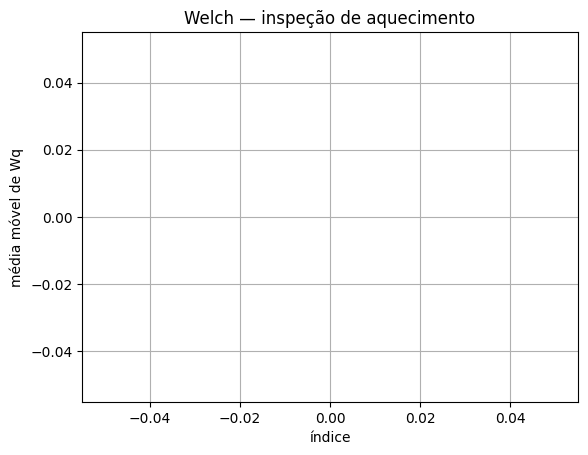

Batching B=20: mean=8.222 ±2.817


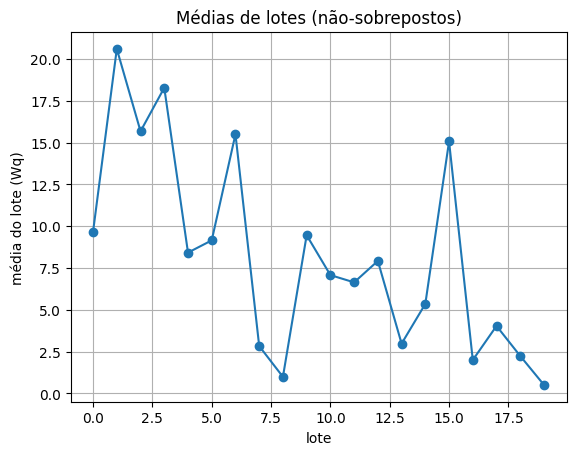

In [54]:
# Welch + batching em um cenário
lam = 11; c = 2
lam_m = lam/60.0; mu_m = 6.0/60.0
res = simulate_run(lam_m, mu_m, c, T=1000.0, warmup=0.0, seed=77)
wq_series = res["Wq_all"]
plot_welch(wq_series, k=200)

B = 20
bm = batch_means(wq_series, B=B)
print(f"Batching B={B}: mean={bm['batch_mean']:.3f} ±{bm['halfwidth95']:.3f}")
import matplotlib.pyplot as plt
plt.figure()
plt.plot(bm["batches"], marker="o")
plt.xlabel("lote"); plt.ylabel("média do lote (Wq)")
plt.title("Médias de lotes (não-sobrepostos)")
plt.grid(True)
plt.show()


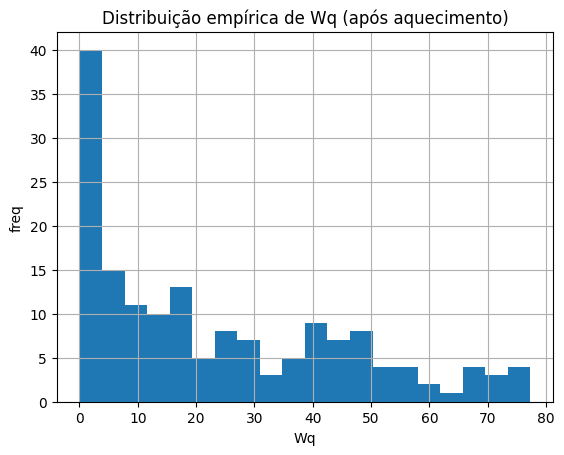

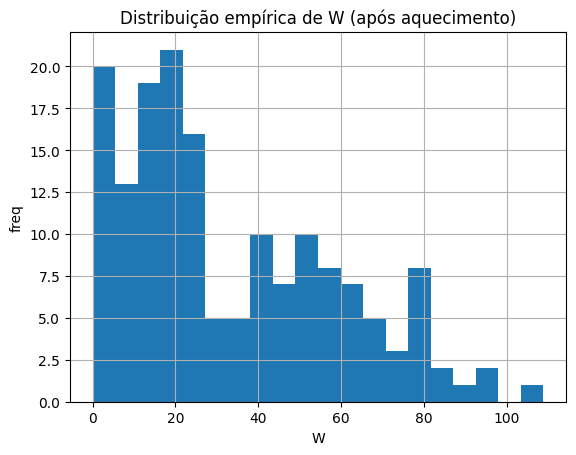

In [ ]:
# Histogramas para depuração/sanidade
lam = 11; c = 2
lam_m = lam/60.0; mu_m = 6.0/60.0
res = simulate_run(lam_m, mu_m, c, T=960.0, warmup=60.0, seed=123)
plt.figure()
plt.hist(res["Wq_all"], bins=20)
plt.xlabel("Wq"); plt.ylabel("freq")
plt.title("Distribuição empírica de Wq (após aquecimento)")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(res["W_all"], bins=20)
plt.xlabel("W"); plt.ylabel("freq")
plt.title("Distribuição empírica de W (após aquecimento)")
plt.grid(True)
plt.show()
